# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [171]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
% matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [172]:
def plot_features(X, model, name):
    '''
    plot random forest features importance
    input: dataframe X and regression model
    output: Feature importance plot
    '''
    print("Plot feature importances…")
    headers = ["name", "score"]
    values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)
    features = forest_feature_importances['name'][:25]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:25]
    #plot feature importances
    plt.figure(figsize=(10,5))
    plt.bar(y_pos, scores, align='center', alpha=0.5)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances' + name)
    plt.show()

## Portfolio dataset

In [173]:
print(portfolio.head())
print("Types of offer:")
portfolio.offer_type.unique()

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
Types of offer:


array(['bogo', 'informational', 'discount'], dtype=object)

['bogo' 'informational' 'discount']


(array([ 4.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  2.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

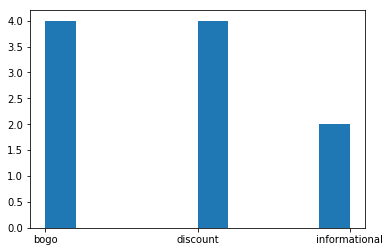

In [174]:
print(portfolio.offer_type.unique())
plt.hist(portfolio['offer_type'])

[10  0  5  3  2]


(array([ 2.,  0.,  2.,  1.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

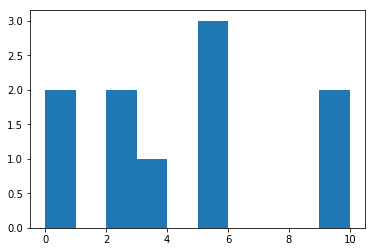

In [175]:
print(portfolio.reward.unique())
plt.hist(portfolio['reward'])

[10  0  5 20  7]


(array([ 2.,  0.,  2.,  1.,  0.,  4.,  0.,  0.,  0.,  1.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

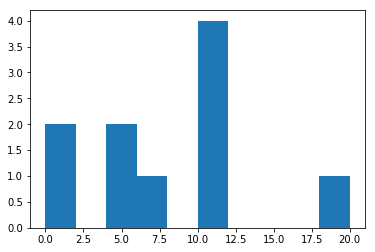

In [176]:
print(portfolio.difficulty.unique())
plt.hist(portfolio['difficulty'])

One can see that rewards correspond to difficulty

## Profile

In [177]:
profile=profile.rename(columns={"id": "person"})
mean_income = profile["income"].mean()
profile['income'] = profile['income'].fillna(mean_income)
print(profile.head())

   age  became_member_on gender                            person  \
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783   
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b   
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5   
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef   
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43   

          income  
0   65404.991568  
1  112000.000000  
2   65404.991568  
3  100000.000000  
4   65404.991568  


In [178]:
profile['gender']=profile['gender'].fillna("O")
profile['income']=profile['income'].fillna("unknown")

## Transcript preprocessing

In [179]:
print(transcript.head())
print(transcript.event.unique())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  
['offer received' 'offer viewed' 'transaction' 'offer completed']


In [180]:
#we do not know which order is completed right away
print(transcript[transcript['event']=="offer completed"].head())

                 event                            person  time  \
12658  offer completed  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672  offer completed  fe97aa22dd3e48c8b143116a8403dd52     0   
12679  offer completed  629fc02d56414d91bca360decdfa9288     0   
12692  offer completed  676506bad68e4161b9bbaffeb039626b     0   
12697  offer completed  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   

                                                   value  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...  


In [181]:
transcript['value']=transcript.value.apply(lambda x: x.get("offer id"))
print(transcript.event.unique())
transcript.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [182]:
print(transcript[transcript['event']=="offer completed"].head())

                 event                            person  time value
12658  offer completed  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0  None
12672  offer completed  fe97aa22dd3e48c8b143116a8403dd52     0  None
12679  offer completed  629fc02d56414d91bca360decdfa9288     0  None
12692  offer completed  676506bad68e4161b9bbaffeb039626b     0  None
12697  offer completed  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0  None


In [183]:
#transcript=transcript.dropna(subset=['value'])
results=transcript[['event', 'person', 'time']][transcript["event"].isin(['transaction', 'offer complete'])]
transcript = transcript.rename(columns={'value': 'id'})
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [184]:
transcript = transcript.sort_values(['person','time'])
transcript = transcript.fillna(method='ffill')

transcript.head()

,event,person,time,id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed


## Put all together

In [185]:
df=pd.merge(portfolio, transcript, on = "id", how="left")
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='bogo']))
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='infomational']))
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='discount']))

df=df.loc[df['offer_type'].isin(['bogo', 'discount'])&df['event'].isin(["offer viewed", "offer completed"])]
df=df.drop_duplicates(subset=["id", "person", "event"])
df_count = df[["id", "person", "event"]].groupby(["id", "person"]).count().rename(columns= {'event': 'event_count'}).reset_index()
df=pd.merge(df, df_count, on=["id", 'person'], how='left')
df['event_count']=df["event_count"].replace(1,0)
df['event_count']=df["event_count"].replace(2,1)
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


16180
0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


16367


,channels,difficulty,duration,id,offer_type,reward,event,person,time,event_count
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,004c5799adbf42868b9cff0396190900,336,0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,005500a7188546ff8a767329a2f7c76a,60,1
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,005500a7188546ff8a767329a2f7c76a,582,1
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,0063def0f9c14bc4805322a488839b32,186,0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,00715b6e55c3431cb56ff7307eb19675,12,1


Bogo and discount offers have event order completed. I will use these types to predict if order is completed.

In [186]:
#exclude events where offer is completed by chance
df=df.loc[~((df['event']=="offer completed")&(df['event_count']==0))]
df=pd.merge(df, profile, on="person", how="left")
print(df.reward.unique())
print(df.duration.unique())
df=df.drop(['event'], axis=1)
#convert became_member_on into days
df['year']=df['became_member_on'].apply(lambda x: int(str(x)[:4]))
df['month']=df['became_member_on'].apply(lambda x: int(str(x)[4:6]) if str(x)[4]=='1' else int(str(x)[-3:-2]))
df['day']=df['became_member_on'].apply(lambda x: int(str(x)[-2:]))
df = df.drop('became_member_on', axis=1, inplace=False)
df.loc[df['year'] == 2018, 'membership_len'] = (30*df['month'].astype('float'))+df['day']
df.loc[df['year'] != 2018, 'membership_len'] = ((2018-df['year'].astype('int'))*365)+(30*df['month'].astype('float'))+df['day']
df = df.drop(['year','month','day'], axis=1, inplace=False)
df.head()

[10  5  3  2]
[ 7  5 10]


,channels,difficulty,duration,id,offer_type,reward,person,time,event_count,age,gender,income,membership_len
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,005500a7188546ff8a767329a2f7c76a,60,1,56,M,47000.000000,734.0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,005500a7188546ff8a767329a2f7c76a,582,1,56,M,47000.000000,734.0
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0063def0f9c14bc4805322a488839b32,186,0,118,O,65404.991568,195.0
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,00715b6e55c3431cb56ff7307eb19675,12,1,58,F,119000.000000,732.0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,00715b6e55c3431cb56ff7307eb19675,36,1,58,F,119000.000000,732.0


(array([ 17462.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  22364.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

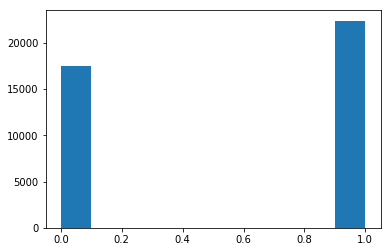

In [187]:
df=df.drop_duplicates(subset =['id', 'person', 'event_count'], keep='first')

plt.hist(df['event_count'])

The outcome is slightly imbalanced. More viewed offers are completed than not completed. 

In [188]:
num_col=["age", 'income', "membership_len"]
cat_col = [i for i in df.columns if i not in num_col+['id', 'person', 'time', 'channels', 'event_count', 'duration']]

In [189]:
df=df.dropna()
le  = LabelEncoder()
for i in cat_col:
    df[i]=le.fit_transform(df[i].astype('category'))
print(cat_col)
X=df[num_col+cat_col]
Y=df['event_count']
X_train, X_test, y_train, y_test = train_test_split(X, Y)
model=RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=accuracy_score(y_test, y_pred)
print("acuracy")
print(score)
score = roc_auc_score(y_test, y_pred)
print("auc score")
score

['difficulty', 'offer_type', 'reward', 'gender']
acuracy
0.690569448629
auc score


0.68639728626492935

Plot feature importances…


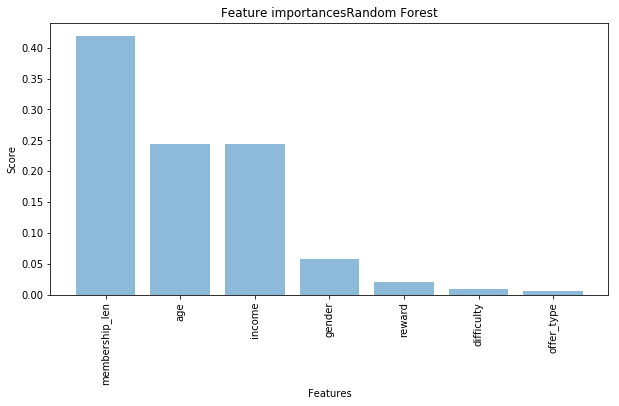

In [190]:
plot_features(X, model, "Random Forest")

Most contributed feature is became_member_on (it is interesting that it contributes and score is good despite I forgot to transform it). AUC score is 0.69 and acuracy is 0.69.

In [191]:
score = cross_validate(RandomForestClassifier(class_weight='balanced'), X, Y, cv=3, scoring='roc_auc')
score

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 0.32235479,  0.31739855,  0.38626432]),
 'score_time': array([ 0.01381969,  0.03014255,  0.02518773]),
 'test_score': array([ 0.62587743,  0.73827383,  0.70992873]),
 'train_score': array([ 0.99195991,  0.99071096,  0.99370052])}